## **IMPORT**

In [12]:
pip install tensorflow


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import random
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler



*   STOCK 1: WALMART- WMT
*   STOCK 2: COCA COLA -KO
*   STOCK 3: NEXT ENERGY- NEE







# SELECT THE STOCKS FOR THE EVALUATION AND EPISODE LENGHT FOR TRAINING

> Blocco con rientro



In [14]:
SELECTED_ISTRUMENTS = ['WMT','KO','NEE']
num_episodes = 40


#**STOCK 1**

## IMPORT DATA

In [15]:
############################################################
##cleaned.csv formation
############################################################

# Define a list of instruments (e.g., stocks or cryptocurrencies)
# also vix in this version

CONFIG_TARGET_INSTRUMENTS = [SELECTED_ISTRUMENTS[0]]

start_date = "2014-01-01"
end_date = "2024-01-01"

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over each instrument
for instrument in CONFIG_TARGET_INSTRUMENTS:
    # Download historical data using yfinance
    historical_data = yf.download(instrument, start=start_date, end=end_date)
    historical_data['instrument'] = instrument
    vix_value = yf.download('^VIX',start=start_date, end=end_date)
    historical_data['VIX'] = vix_value['Close']

    # Reset the index to make 'Date' a column
    historical_data = historical_data.reset_index()
    #historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d 16:00:00%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S%z').dt.tz_localize('US/Pacific')


    # lower case columns
    historical_data.columns = historical_data.columns.str.lower()

    ####################################################


    # Calculate the Typical Price
    typical_price = (historical_data['high'] + historical_data['low'] + historical_data['close']) / 3

    # Calculate the Traded Value (Typical Price * Volume)
    traded_value = typical_price * historical_data['volume']

    # Calculate Cumulative Traded Value
    cumulative_traded_value = traded_value.cumsum()

    # Calculate Cumulative Volume
    cumulative_volume = historical_data['volume'].cumsum()

    # Calculate VWAP
    vwap = cumulative_traded_value / cumulative_volume

    historical_data['weightedAverage'] = vwap
    ####################################################

    historical_data['quoteVolume'] = historical_data['volume'] * historical_data['weightedAverage']
    ####################################################

    # Merge the current instrument's data with the combined data
    if combined_data.empty:
        combined_data = historical_data
    else:
        combined_data=pd.concat([combined_data,historical_data], axis=0, ignore_index=True)

# Sort the combined data by date
combined_data = combined_data.sort_values(by='date')

# Reset index for the final combined data
combined_data = combined_data.reset_index(drop=True)

# Define the desired order of columns
desired_order = ['date', 'instrument', 'high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage', 'vix']
combined_data = combined_data[desired_order]


####################################################
combined_data = combined_data.dropna()
####################################################
#rounding to 8 decimals
combined_data = combined_data.round(8)
#combined_data['date'] = pd.to_datetime(combined_data['date'])

combined_data.to_csv('cleaned.csv', index=False)
####################################################
combined_data = combined_data.drop('instrument',axis=1)
# Display the result
combined_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,date,high,low,open,close,volume,quoteVolume,weightedAverage,vix
0,2014-01-02 16:00:00-08:00,79.470001,78.500000,78.720001,78.910004,6878000,5.430869e+08,78.960002,14.23
1,2014-01-03 16:00:00-08:00,79.129997,78.519997,78.809998,78.650002,4957400,3.910349e+08,78.879020,13.76
2,2014-01-06 16:00:00-08:00,78.910004,77.790001,78.860001,78.209999,7280200,5.726589e+08,78.659770,13.55
3,2014-01-07 16:00:00-08:00,78.849998,77.919998,78.169998,78.449997,5012300,3.940028e+08,78.607190,12.92
4,2014-01-08 16:00:00-08:00,78.510002,77.599998,78.500000,77.830002,5955200,4.673822e+08,78.483033,12.87
...,...,...,...,...,...,...,...,...,...
2511,2023-12-22 16:00:00-08:00,157.149994,155.160004,155.449997,156.649994,6467400,6.712156e+08,103.784450,13.03
2512,2023-12-26 16:00:00-08:00,156.990005,156.110001,156.649994,156.410004,3893300,4.041032e+08,103.794529,12.99
2513,2023-12-27 16:00:00-08:00,157.949997,156.160004,156.309998,157.880005,6632000,6.884809e+08,103.811957,12.43
2514,2023-12-28 16:00:00-08:00,158.330002,157.500000,157.770004,157.570007,5592000,5.805993e+08,103.826772,12.47


In [16]:
############################################################
##cleaned_preprocessed.csv formation
############################################################
import pandas as pd
FILE = "cleaned.csv"
df = pd.read_csv(FILE)

INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
############################################################

COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage','vix']
SCOLS = ["vh","vl","vc","open_s","volume_s","quoteVolume_s","weightedAverage_s",'vix']
OBS_COLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
EPISODE_LENGTH = 500


df["date"] = df["date"].apply(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'))
df = df[df["instrument"].isin(INSTRUMENTS)].sort_values("date")
df["vh"] = df["high"]/df["open"]
df["vl"] = df["low"]/df["open"]
df["vc"] = df["close"]/df["open"]
df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
df["volume_s"] = df.groupby("instrument")["volume"].apply(lambda x: x - x.shift(1))
df["quoteVolume_s"] = df.groupby("instrument")["quoteVolume"].apply(lambda x: x - x.shift(1))
df["weightedAverage_s"] = df.groupby("instrument")["weightedAverage"].apply(lambda x: x - x.shift(1))
df["vix"] = df.groupby("instrument")["vix"].apply(lambda x: x - x.shift(1))

new_cols = []

for col in SCOLS:
    print(col)
    df[col+"_roll_7"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(7).mean().bfill())
    new_cols.append(col+"_roll_7")
    df[col+"_roll_14"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(14).mean().bfill())
    new_cols.append(col+"_roll_14")
    df[col+"_roll_30"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(30).mean().bfill())
    new_cols.append(col+"_roll_30")

SCOLS.extend(new_cols)
print(SCOLS)
###############################
df = df.dropna()
df = df.reset_index(drop=True)
cut_off_date = pd.Timestamp("2023-01-01", tz='US/Pacific') ## CUT DATE FOR TRAINING AND TEST DATA

# Filter data based on the cut-off date
train_data = df[df['date'] < cut_off_date]
test_data = df[df['date'] >= cut_off_date]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-ffd2d6ead600>:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
<ipython-input-16-ffd2d6ead600>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the fu

vh
vl
vc
open_s
volume_s
quoteVolume_s
weightedAverage_s
vix
['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vix', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', 'vix_roll_14', 'vix_roll_30']


<ipython-input-16-ffd2d6ead600>:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col+"_roll_14"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(14).mean().bfill())
<ipython-input-16-ffd2d6ead600>:37: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col+"_roll_30"] = df.groupby("in

In [17]:
##########################
###config.py: ASSETS
##########################

CONFIG_FILE = "train_data.csv"
CONFIG_INSTRUMENTS_placeholder = ['ASST1']
#CONFIG_INSTRUMENTS = ['AAPL', 'GOOGL', 'MSFT']  #EXAMPLE
CONFIG_INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
CONFIG_COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage', 'vix']
CONFIG_SCOLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', \
                'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', \
                'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', \
                'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', \
                'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
CONFIG_OBS_COLS = ['ASST1_vh', 'ASST1_vl', 'ASST1_vc','ASST1_open_s', 'ASST1_volume_s', 'ASST1_quoteVolume_s', 'ASST1_weightedAverage_s','ASST1_vh_roll_7', 'ASST1_vh_roll_14', 'ASST1_vh_roll_30', 'ASST1_vl_roll_7', \
                    'ASST1_vl_roll_14', 'ASST1_vl_roll_30','ASST1_vc_roll_7', 'ASST1_vc_roll_14', 'ASST1_vc_roll_30', 'ASST1_open_s_roll_7', 'ASST1_open_s_roll_14', 'ASST1_open_s_roll_30', \
                       'ASST1_volume_s_roll_7', 'ASST1_volume_s_roll_14', 'ASST1_volume_s_roll_30', 'ASST1_quoteVolume_s_roll_7', 'ASST1_quoteVolume_s_roll_14', \
                           'ASST1_quoteVolume_s_roll_30', 'ASST1_weightedAverage_s_roll_7', 'ASST1_weightedAverage_s_roll_14', 'ASST1_weightedAverage_s_roll_30', 'ASST1_vix_roll_7', 'ASST1_vix_roll_14', 'ASST1_vix_roll_30']
# Perform the replacement of placeholders.
CONFIG_OBS_COLS = [col.replace(placeholder, instrument) for col, placeholder, instrument in zip(CONFIG_OBS_COLS, CONFIG_INSTRUMENTS_placeholder * len(CONFIG_OBS_COLS), CONFIG_INSTRUMENTS * len(CONFIG_OBS_COLS))]
ALL_COL = CONFIG_COLS + CONFIG_SCOLS
#####################################################
# Checkining contets of CONFIG_OBS_COLS
inline_string = ', '.join(CONFIG_OBS_COLS)
# Printing the result
print(inline_string)

WMT_vh, WMT_vl, WMT_vc, WMT_open_s, WMT_volume_s, WMT_quoteVolume_s, WMT_weightedAverage_s, WMT_vh_roll_7, WMT_vh_roll_14, WMT_vh_roll_30, WMT_vl_roll_7, WMT_vl_roll_14, WMT_vl_roll_30, WMT_vc_roll_7, WMT_vc_roll_14, WMT_vc_roll_30, WMT_open_s_roll_7, WMT_open_s_roll_14, WMT_open_s_roll_30, WMT_volume_s_roll_7, WMT_volume_s_roll_14, WMT_volume_s_roll_30, WMT_quoteVolume_s_roll_7, WMT_quoteVolume_s_roll_14, WMT_quoteVolume_s_roll_30, WMT_weightedAverage_s_roll_7, WMT_weightedAverage_s_roll_14, WMT_weightedAverage_s_roll_30, WMT_vix_roll_7, WMT_vix_roll_14, WMT_vix_roll_30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  **SETTING THE DEEP Q MODEL**

In [18]:


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(50, input_dim=self.state_size, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state.reshape((1, self.state_size))) ###

        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0]))


            target_f = self.model.predict(state.reshape(1, -1)) ##

            target_f[0, int(action)] = target[0]

            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## **SETTING THE TRADING ENVIRONMENT**





In [19]:
class StockTradingEnvironment(gym.Env):
    def __init__(self, data, window_size, trading_fee, initial_balance=1000000):
        super(StockTradingEnvironment, self).__init__()

        self.data = data
        self.window_size = window_size
        self.trading_fee = trading_fee
        self.initial_balance = initial_balance
        self.current_step = window_size

        # Action space: 0 = BUY, 1 = HOLD, 2 = SHORT
        self.action_space = spaces.Discrete(3)

        # Observation space:
        self.observation_space = spaces.Box(low=0, high=1, shape=(39,))

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.balance
        return self._get_observation()

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step == len(self.data) - 1:
            done = True
        else:
            done = False

        obs = self._get_observation()
        reward = self._calculate_reward()

        return obs, reward, done, {}

    def _get_observation(self):
        obs = [self.data[ALL_COL].iloc[self.current_step]]

        return np.array(obs)

    def _take_action(self, action):
        current_price = self.data['close'].iloc[self.current_step]

        if action == 0:  # BUY
            self.shares_held += (self.balance / current_price) * (1 - self.trading_fee)
            self.balance -= self.balance * self.trading_fee
        elif action == 1:  # HOLD
            pass
        elif action == 2:  # SHORT
            self.balance += self.shares_held * current_price * (1 - self.trading_fee)
            self.shares_held = 0

        self.net_worth = self.balance + (self.shares_held * current_price)

    def _calculate_reward(self):
        prev_net_worth = self.net_worth - self.balance
        current_net_worth = self._get_observation()[0] - self.balance
        return current_net_worth - prev_net_worth

##**SETTING THE ENVIRONMENT**

In [20]:
# Initialize trading environment with real data
env_train = StockTradingEnvironment(train_data, window_size=5, trading_fee=0)
env_test = StockTradingEnvironment(test_data, window_size=5, trading_fee=0)

# DQN
# num_episodes = 5
batch_size = 32
state_size = env_train.observation_space.shape[0]
action_size = env_train.action_space.n

agent = DQNAgent(state_size, action_size)

## **TRAIN**

In [21]:

# Store results for plotting
all_states_train = []
all_actions_train = []
all_rewards_train = []

all_states_test = []
all_actions_test = []
all_rewards_test = []

state_index_train = 0
state_index_test = 0

for episode in range(num_episodes):
    # Training
    state_train = env_train.reset()
    episode_states_train = []
    episode_actions_train = []
    episode_rewards_train = []

    while True:
        action_train = agent.act(state_train)
        next_state_train, reward_train, done_train, _ = env_train.step(action_train)
        agent.remember(state_train, action_train, reward_train, next_state_train, done_train)
        episode_states_train.append(state_index_train)
        episode_actions_train.append(action_train)
        episode_rewards_train.append(reward_train)
        state_train = next_state_train
        state_index_train += 1

        if done_train:
            break

    # Replay and train the agent
    agent.replay(batch_size)

    # Testing
    state_test = env_test.reset()
    episode_states_test = []
    episode_actions_test = []
    episode_rewards_test = []

    while True:
        action_test = agent.act(state_test)
        next_state_test, reward_test, done_test, _ = env_test.step(action_test)
        episode_states_test.append(state_index_test)
        episode_actions_test.append(action_test)
        episode_rewards_test.append(reward_test)
        state_test = next_state_test
        state_index_test += 1

        if done_test:
            break

    # Store results for plotting
    all_states_train.extend(episode_states_train)
    all_actions_train.extend(episode_actions_train)
    all_rewards_train.extend(episode_rewards_train)

    all_states_test.extend(episode_states_test)
    all_actions_test.extend(episode_actions_test)
    all_rewards_test.extend(episode_rewards_test)

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 25ms/step


## **SIMULATION AND PLOTTING**

In [22]:
# Initialize portfolio variables for simulation
initial_balance_simulation = 1000000  # Initial balance for simulation
balance_simulation = initial_balance_simulation
shares_held_simulation = 0
portfolio_returns_simulation = []
strategy1_actions = []

# Use testing data instead of actual_prices
testing_prices = test_data.values
testing_prices = np.array([inner_array[2:] for inner_array in testing_prices]).astype(np.float32)

for i in range(len(testing_prices)):
    current_price_simulation = testing_prices[i]

    # Execute action from DQ-learning model: 0 = BUY, 1 = HOLD, 2 = SHORT
    state_simulation = np.array([testing_prices[i]
    ])
    state_simulation = np.reshape(state_simulation, [1, state_size])
    action_simulation = agent.act(state_simulation)

    if action_simulation == 0:  # BUY
        shares_bought_simulation = balance_simulation / current_price_simulation
        balance_simulation -= shares_bought_simulation * current_price_simulation
        shares_held_simulation += shares_bought_simulation
    elif action_simulation == 2:  # SHORT
        balance_simulation += shares_held_simulation * current_price_simulation
        shares_held_simulation = 0
    strategy1_actions.append(action_simulation)
    # Calculate portfolio return at the current time step for simulation
    portfolio_return_simulation = (
        (balance_simulation + shares_held_simulation * current_price_simulation) / initial_balance_simulation - 1
    )
    portfolio_returns_simulation.append(portfolio_return_simulation)

# Convert portfolio returns to a NumPy array for simulation
portfolio_returns_simulation = np.array(portfolio_returns_simulation)

1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 24ms/step


<ipython-input-22-29a66635ba2d>:22: RuntimeWarning: invalid value encountered in divide
  shares_bought_simulation = balance_simulation / current_price_simulation


1/1 [==============================] - 0s 61ms/step


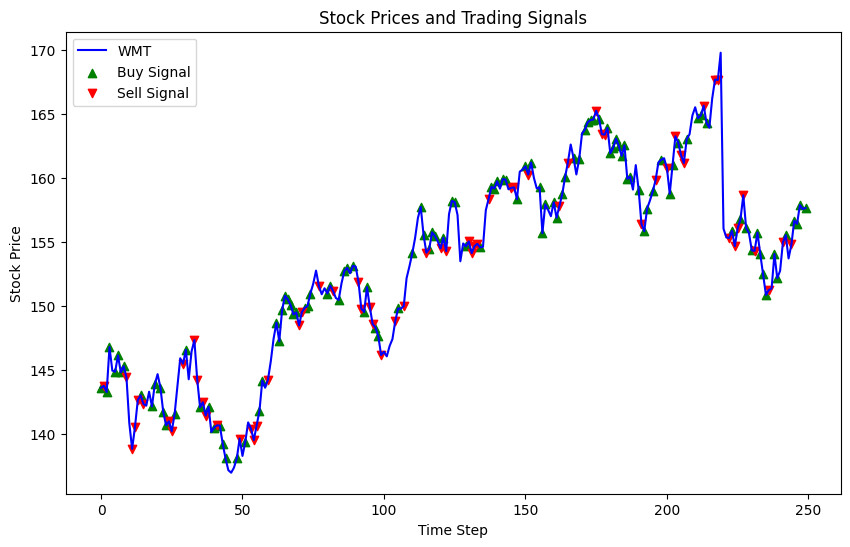

In [23]:
testing_prices = test_data['close']
testing_prices
# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i, action in enumerate(strategy1_actions) if action == 0]
sell_signals = [i for i, action in enumerate(strategy1_actions) if action == 2]
# Plot actual stock prices
plt.figure(figsize=(10, 6))
plt.plot(np.array(testing_prices), label=SELECTED_ISTRUMENTS[0], color='blue')

# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i in buy_signals if i < len(testing_prices)]
sell_signals = [i for i in sell_signals if i < len(testing_prices)]

plt.scatter(buy_signals, [np.array(testing_prices.iloc[i]) for i in buy_signals], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals, [np.array(testing_prices.iloc[i]) for i in sell_signals], marker='v', color='red', label='Sell Signal')

plt.title('Stock Prices and Trading Signals')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [24]:
cumulative_portfolio_returns= [el +1 for el in portfolio_returns_simulation[:,0]]


strategy_1_value= [ el *100 for el in cumulative_portfolio_returns]
strategy_1_returns = pd.Series(strategy_1_value).pct_change()

stock_1_returns = test_data['close'].pct_change()

stock_1_value= np.array((1 + stock_1_returns).cumprod() * 100)

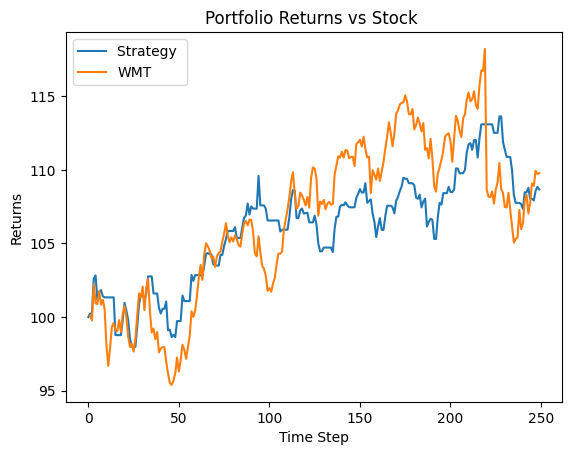

In [25]:
# Calculate stock returns for testing data


# Plot
plt.plot(strategy_1_value, label='Strategy ')
plt.plot(stock_1_value, label=SELECTED_ISTRUMENTS[0])
plt.legend()
plt.title('Portfolio Returns vs Stock ')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.show()

# **STOCK 2**

## **IMPORT**

## IMPORT DATA

In [26]:
############################################################
##cleaned.csv formation
############################################################

# Define a list of instruments (e.g., stocks or cryptocurrencies)
# also vix in this version

CONFIG_TARGET_INSTRUMENTS = [SELECTED_ISTRUMENTS[1]]

start_date = "2014-01-01"
end_date = "2024-01-01"

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over each instrument
for instrument in CONFIG_TARGET_INSTRUMENTS:
    # Download historical data using yfinance
    historical_data = yf.download(instrument, start=start_date, end=end_date)
    historical_data['instrument'] = instrument
    vix_value = yf.download('^VIX',start=start_date, end=end_date)
    historical_data['VIX'] = vix_value['Close']

    # Reset the index to make 'Date' a column
    historical_data = historical_data.reset_index()
    #historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d 16:00:00%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S%z').dt.tz_localize('US/Pacific')


    # lower case columns
    historical_data.columns = historical_data.columns.str.lower()

    ####################################################


    # Calculate the Typical Price
    typical_price = (historical_data['high'] + historical_data['low'] + historical_data['close']) / 3

    # Calculate the Traded Value (Typical Price * Volume)
    traded_value = typical_price * historical_data['volume']

    # Calculate Cumulative Traded Value
    cumulative_traded_value = traded_value.cumsum()

    # Calculate Cumulative Volume
    cumulative_volume = historical_data['volume'].cumsum()

    # Calculate VWAP
    vwap = cumulative_traded_value / cumulative_volume

    historical_data['weightedAverage'] = vwap
    ####################################################

    historical_data['quoteVolume'] = historical_data['volume'] * historical_data['weightedAverage']
    ####################################################

    # Merge the current instrument's data with the combined data
    if combined_data.empty:
        combined_data = historical_data
    else:
        combined_data=pd.concat([combined_data,historical_data], axis=0, ignore_index=True)

# Sort the combined data by date
combined_data = combined_data.sort_values(by='date')

# Reset index for the final combined data
combined_data = combined_data.reset_index(drop=True)

# Define the desired order of columns
desired_order = ['date', 'instrument', 'high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage', 'vix']
combined_data = combined_data[desired_order]


####################################################
combined_data = combined_data.dropna()
####################################################
#rounding to 8 decimals
combined_data = combined_data.round(8)
#combined_data['date'] = pd.to_datetime(combined_data['date'])

combined_data.to_csv('cleaned.csv', index=False)
####################################################
combined_data = combined_data.drop('instrument',axis=1)
# Display the result
combined_data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,date,high,low,open,close,volume,quoteVolume,weightedAverage,vix
0,2014-01-02 16:00:00-08:00,41.230000,40.509998,41.119999,40.660000,12698600,5.181029e+08,40.799999,14.23
1,2014-01-03 16:00:00-08:00,40.730000,40.349998,40.680000,40.459999,10403400,4.231157e+08,40.670906,13.76
2,2014-01-06 16:00:00-08:00,40.590000,40.160000,40.480000,40.270000,11036300,4.476757e+08,40.563930,13.55
3,2014-01-07 16:00:00-08:00,40.720001,40.290001,40.480000,40.389999,11872300,4.812892e+08,40.538833,12.92
4,2014-01-08 16:00:00-08:00,40.439999,39.830002,40.439999,39.939999,15339600,6.200513e+08,40.421609,12.87
...,...,...,...,...,...,...,...,...,...
2511,2023-12-22 16:00:00-08:00,58.459999,58.020000,58.119999,58.320000,9028500,4.438983e+08,49.166340,13.03
2512,2023-12-26 16:00:00-08:00,58.709999,58.060001,58.060001,58.560001,6422500,3.157815e+08,49.168003,12.99
2513,2023-12-27 16:00:00-08:00,58.770000,58.400002,58.639999,58.709999,8560100,4.209024e+08,49.170264,12.43
2514,2023-12-28 16:00:00-08:00,58.869999,58.529999,58.650002,58.750000,8400100,4.130539e+08,49.172502,12.47


In [27]:
############################################################
##cleaned_preprocessed.csv formation
############################################################
import pandas as pd
FILE = "cleaned.csv"
df = pd.read_csv(FILE)

INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
############################################################

COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage','vix']
SCOLS = ["vh","vl","vc","open_s","volume_s","quoteVolume_s","weightedAverage_s",'vix']
OBS_COLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
EPISODE_LENGTH = 500


df["date"] = df["date"].apply(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'))
df = df[df["instrument"].isin(INSTRUMENTS)].sort_values("date")
df["vh"] = df["high"]/df["open"]
df["vl"] = df["low"]/df["open"]
df["vc"] = df["close"]/df["open"]
df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
df["volume_s"] = df.groupby("instrument")["volume"].apply(lambda x: x - x.shift(1))
df["quoteVolume_s"] = df.groupby("instrument")["quoteVolume"].apply(lambda x: x - x.shift(1))
df["weightedAverage_s"] = df.groupby("instrument")["weightedAverage"].apply(lambda x: x - x.shift(1))
df["vix"] = df.groupby("instrument")["vix"].apply(lambda x: x - x.shift(1))

new_cols = []

for col in SCOLS:
    print(col)
    df[col+"_roll_7"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(7).mean().bfill())
    new_cols.append(col+"_roll_7")
    df[col+"_roll_14"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(14).mean().bfill())
    new_cols.append(col+"_roll_14")
    df[col+"_roll_30"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(30).mean().bfill())
    new_cols.append(col+"_roll_30")

SCOLS.extend(new_cols)
print(SCOLS)
###############################
df = df.dropna()
df = df.reset_index(drop=True)
cut_off_date = pd.Timestamp("2023-01-01", tz='US/Pacific') ## CUT DATE FOR TRAINING AND TEST DATA

# Filter data based on the cut-off date
train_data = df[df['date'] < cut_off_date]
test_data = df[df['date'] >= cut_off_date]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


vh
vl
vc
open_s
volume_s
quoteVolume_s
weightedAverage_s
vix
['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vix', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', 'vix_roll_14', 'vix_roll_30']


<ipython-input-27-ffd2d6ead600>:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
<ipython-input-27-ffd2d6ead600>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["volume_s"] = df.groupby("instrument")["volume"].

In [28]:
##########################
###config.py: ASSETS
##########################

CONFIG_FILE = "train_data.csv"
CONFIG_INSTRUMENTS_placeholder = ['ASST1']
#CONFIG_INSTRUMENTS = ['AAPL', 'GOOGL', 'MSFT']  #EXAMPLE
CONFIG_INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
CONFIG_COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage', 'vix']
CONFIG_SCOLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', \
                'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', \
                'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', \
                'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', \
                'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
CONFIG_OBS_COLS = ['ASST1_vh', 'ASST1_vl', 'ASST1_vc','ASST1_open_s', 'ASST1_volume_s', 'ASST1_quoteVolume_s', 'ASST1_weightedAverage_s','ASST1_vh_roll_7', 'ASST1_vh_roll_14', 'ASST1_vh_roll_30', 'ASST1_vl_roll_7', \
                    'ASST1_vl_roll_14', 'ASST1_vl_roll_30','ASST1_vc_roll_7', 'ASST1_vc_roll_14', 'ASST1_vc_roll_30', 'ASST1_open_s_roll_7', 'ASST1_open_s_roll_14', 'ASST1_open_s_roll_30', \
                       'ASST1_volume_s_roll_7', 'ASST1_volume_s_roll_14', 'ASST1_volume_s_roll_30', 'ASST1_quoteVolume_s_roll_7', 'ASST1_quoteVolume_s_roll_14', \
                           'ASST1_quoteVolume_s_roll_30', 'ASST1_weightedAverage_s_roll_7', 'ASST1_weightedAverage_s_roll_14', 'ASST1_weightedAverage_s_roll_30', 'ASST1_vix_roll_7', 'ASST1_vix_roll_14', 'ASST1_vix_roll_30']
# Perform the replacement of placeholders.
CONFIG_OBS_COLS = [col.replace(placeholder, instrument) for col, placeholder, instrument in zip(CONFIG_OBS_COLS, CONFIG_INSTRUMENTS_placeholder * len(CONFIG_OBS_COLS), CONFIG_INSTRUMENTS * len(CONFIG_OBS_COLS))]
ALL_COL = CONFIG_COLS + CONFIG_SCOLS
#####################################################
# Checkining contets of CONFIG_OBS_COLS
inline_string = ', '.join(CONFIG_OBS_COLS)
# Printing the result
print(inline_string)

KO_vh, KO_vl, KO_vc, KO_open_s, KO_volume_s, KO_quoteVolume_s, KO_weightedAverage_s, KO_vh_roll_7, KO_vh_roll_14, KO_vh_roll_30, KO_vl_roll_7, KO_vl_roll_14, KO_vl_roll_30, KO_vc_roll_7, KO_vc_roll_14, KO_vc_roll_30, KO_open_s_roll_7, KO_open_s_roll_14, KO_open_s_roll_30, KO_volume_s_roll_7, KO_volume_s_roll_14, KO_volume_s_roll_30, KO_quoteVolume_s_roll_7, KO_quoteVolume_s_roll_14, KO_quoteVolume_s_roll_30, KO_weightedAverage_s_roll_7, KO_weightedAverage_s_roll_14, KO_weightedAverage_s_roll_30, KO_vix_roll_7, KO_vix_roll_14, KO_vix_roll_30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  **SETTING THE DEEP Q MODEL**

In [29]:


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(50, input_dim=self.state_size, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state.reshape((1, self.state_size))) ###

        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0]))


            target_f = self.model.predict(state.reshape(1, -1)) ##

            target_f[0, int(action)] = target[0]

            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## **SETTING THE TRADING ENVIRONMENT**





In [30]:
class StockTradingEnvironment(gym.Env):
    def __init__(self, data, window_size, trading_fee, initial_balance=1000000):
        super(StockTradingEnvironment, self).__init__()

        self.data = data
        self.window_size = window_size
        self.trading_fee = trading_fee
        self.initial_balance = initial_balance
        self.current_step = window_size

        # Action space: 0 = BUY, 1 = HOLD, 2 = SHORT
        self.action_space = spaces.Discrete(3)

        # Observation space:
        self.observation_space = spaces.Box(low=0, high=1, shape=(39,))

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.balance
        return self._get_observation()

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step == len(self.data) - 1:
            done = True
        else:
            done = False

        obs = self._get_observation()
        reward = self._calculate_reward()

        return obs, reward, done, {}

    def _get_observation(self):
        obs = [self.data[ALL_COL].iloc[self.current_step]]

        return np.array(obs)

    def _take_action(self, action):
        current_price = self.data['close'].iloc[self.current_step]

        if action == 0:  # BUY
            self.shares_held += (self.balance / current_price) * (1 - self.trading_fee)
            self.balance -= self.balance * self.trading_fee
        elif action == 1:  # HOLD
            pass
        elif action == 2:  # SHORT
            self.balance += self.shares_held * current_price * (1 - self.trading_fee)
            self.shares_held = 0

        self.net_worth = self.balance + (self.shares_held * current_price)

    def _calculate_reward(self):
        prev_net_worth = self.net_worth - self.balance
        current_net_worth = self._get_observation()[0] - self.balance
        return current_net_worth - prev_net_worth

##**SETTING THE ENVIRONMENT**





In [31]:

# Initialize trading environment with real data
env_train = StockTradingEnvironment(train_data, window_size=5, trading_fee=0)
env_test = StockTradingEnvironment(test_data, window_size=5, trading_fee=0)

# DQN
# num_episodes = 50
# batch_size = 32
state_size = env_train.observation_space.shape[0]
action_size = env_train.action_space.n

agent = DQNAgent(state_size, action_size)

In [32]:
# Assuming daily frequency
num_steps_per_episode = len(train_data)  # or len(test_data)
print("Number of steps per episode:", num_steps_per_episode)

Number of steps per episode: 2265


## **TRAIN**

In [33]:

# Store results for plotting
all_states_train = []
all_actions_train = []
all_rewards_train = []

all_states_test = []
all_actions_test = []
all_rewards_test = []

state_index_train = 0
state_index_test = 0

for episode in range(num_episodes):
    # Training
    state_train = env_train.reset()
    episode_states_train = []
    episode_actions_train = []
    episode_rewards_train = []

    while True:
        action_train = agent.act(state_train)
        next_state_train, reward_train, done_train, _ = env_train.step(action_train)
        agent.remember(state_train, action_train, reward_train, next_state_train, done_train)
        episode_states_train.append(state_index_train)
        episode_actions_train.append(action_train)
        episode_rewards_train.append(reward_train)
        state_train = next_state_train
        state_index_train += 1

        if done_train:
            break

    # Replay and train the agent
    agent.replay(batch_size)

    # Testing
    state_test = env_test.reset()
    episode_states_test = []
    episode_actions_test = []
    episode_rewards_test = []

    while True:
        action_test = agent.act(state_test)
        next_state_test, reward_test, done_test, _ = env_test.step(action_test)
        episode_states_test.append(state_index_test)
        episode_actions_test.append(action_test)
        episode_rewards_test.append(reward_test)
        state_test = next_state_test
        state_index_test += 1

        if done_test:
            break

    # Store results for plotting
    all_states_train.extend(episode_states_train)
    all_actions_train.extend(episode_actions_train)
    all_rewards_train.extend(episode_rewards_train)

    all_states_test.extend(episode_states_test)
    all_actions_test.extend(episode_actions_test)
    all_rewards_test.extend(episode_rewards_test)


Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 26ms/step


## **SIMULATION AND PLOTTING**

In [34]:
# Initialize portfolio variables for simulation
initial_balance_simulation = 1000000  # Initial balance for simulation
balance_simulation = initial_balance_simulation
shares_held_simulation = 0
portfolio_returns_simulation = []
strategy2_actions =[]

# Use testing data instead of actual_prices
testing_prices = test_data.values
testing_prices = np.array([inner_array[2:] for inner_array in testing_prices]).astype(np.float32)

for i in range(len(testing_prices)):
    current_price_simulation = testing_prices[i]

    # Execute action from DQ-learning model: 0 = BUY, 1 = HOLD, 2 = SHORT
    state_simulation = np.array([testing_prices[i]
    ])
    state_simulation = np.reshape(state_simulation, [1, state_size])
    action_simulation = agent.act(state_simulation)

    if action_simulation == 0:  # BUY
        shares_bought_simulation = balance_simulation / current_price_simulation
        balance_simulation -= shares_bought_simulation * current_price_simulation
        shares_held_simulation += shares_bought_simulation
    elif action_simulation == 2:  # SHORT
        balance_simulation += shares_held_simulation * current_price_simulation
        shares_held_simulation = 0

    strategy2_actions.append(action_simulation)
    # Calculate portfolio return at the current time step for simulation
    portfolio_return_simulation = (
        (balance_simulation + shares_held_simulation * current_price_simulation) / initial_balance_simulation - 1
    )
    portfolio_returns_simulation.append(portfolio_return_simulation)

# Convert portfolio returns to a NumPy array for simulation
portfolio_returns_simulation = np.array(portfolio_returns_simulation)

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 25ms/step


<ipython-input-34-3aa289161cca>:22: RuntimeWarning: divide by zero encountered in divide
  shares_bought_simulation = balance_simulation / current_price_simulation
<ipython-input-34-3aa289161cca>:23: RuntimeWarning: invalid value encountered in multiply
  balance_simulation -= shares_bought_simulation * current_price_simulation
<ipython-input-34-3aa289161cca>:32: RuntimeWarning: invalid value encountered in multiply
  (balance_simulation + shares_held_simulation * current_price_simulation) / initial_balance_simulation - 1


1/1 [==============================] - 0s 57ms/step


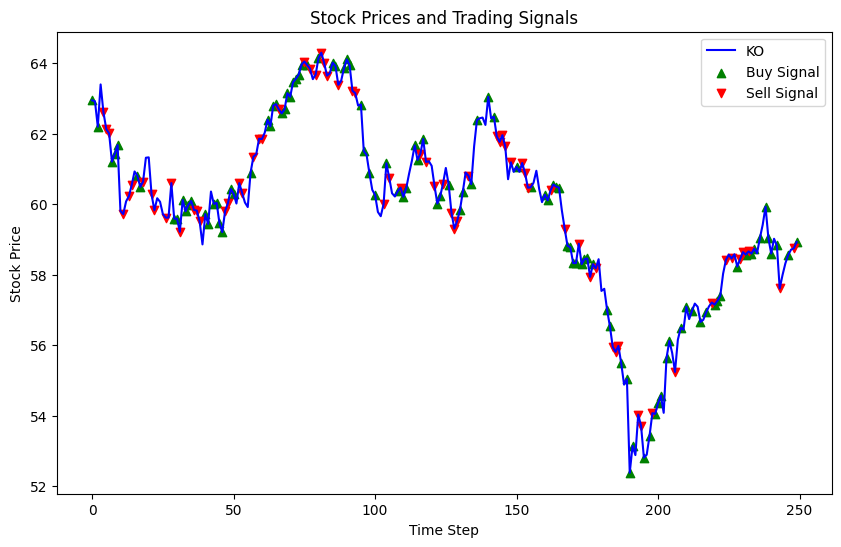

In [35]:
testing_prices = test_data['close']
testing_prices
# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i, action in enumerate(strategy2_actions) if action == 0]
sell_signals = [i for i, action in enumerate(strategy2_actions) if action == 2]
# Plot actual stock prices
plt.figure(figsize=(10, 6))
plt.plot(np.array(testing_prices), label=SELECTED_ISTRUMENTS[1], color='blue')

# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i in buy_signals if i < len(testing_prices)]
sell_signals = [i for i in sell_signals if i < len(testing_prices)]

plt.scatter(buy_signals, [np.array(testing_prices.iloc[i]) for i in buy_signals], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals, [np.array(testing_prices.iloc[i]) for i in sell_signals], marker='v', color='red', label='Sell Signal')

plt.title('Stock Prices and Trading Signals')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
cumulative_portfolio_returns= [el +1 for el in portfolio_returns_simulation[:,0]]


strategy_2_value= [ el *100 for el in cumulative_portfolio_returns]
strategy_2_returns = pd.Series(strategy_2_value).pct_change()



stock_2_returns = test_data['close'].pct_change()

stock_2_value= np.array((1 + stock_2_returns).cumprod() * 100)

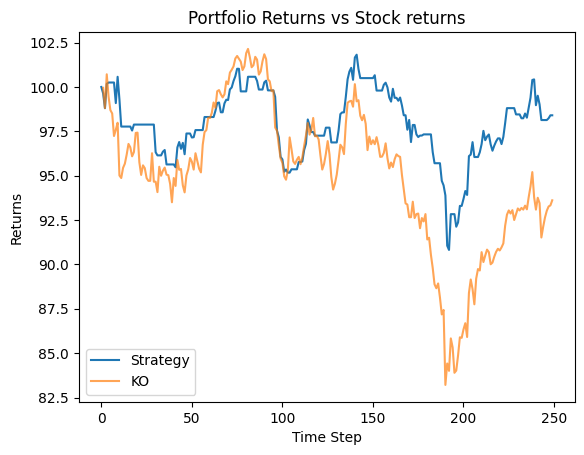

In [37]:
# Calculate stock returns for testing data

# Plot
plt.plot(strategy_2_value, label='Strategy' )
plt.plot(stock_2_value, label=SELECTED_ISTRUMENTS[1], alpha=0.7)
plt.legend()
plt.title('Portfolio Returns vs Stock returns')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.show()

# **STOCK 3**




## IMPORT DATA

In [38]:
############################################################
##cleaned.csv formation
############################################################

# Define a list of instruments (e.g., stocks or cryptocurrencies)
# also vix in this version

CONFIG_TARGET_INSTRUMENTS = [SELECTED_ISTRUMENTS[2]]

start_date = "2014-01-01"
end_date = "2024-01-01"

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over each instrument
for instrument in CONFIG_TARGET_INSTRUMENTS:
    # Download historical data using yfinance
    historical_data = yf.download(instrument, start=start_date, end=end_date)
    historical_data['instrument'] = instrument
    vix_value = yf.download('^VIX',start=start_date, end=end_date)
    historical_data['VIX'] = vix_value['Close']

    # Reset the index to make 'Date' a column
    historical_data = historical_data.reset_index()
    #historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d 16:00:00%z')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S%z').dt.tz_localize('US/Pacific')


    # lower case columns
    historical_data.columns = historical_data.columns.str.lower()

    ####################################################


    # Calculate the Typical Price
    typical_price = (historical_data['high'] + historical_data['low'] + historical_data['close']) / 3

    # Calculate the Traded Value (Typical Price * Volume)
    traded_value = typical_price * historical_data['volume']

    # Calculate Cumulative Traded Value
    cumulative_traded_value = traded_value.cumsum()

    # Calculate Cumulative Volume
    cumulative_volume = historical_data['volume'].cumsum()

    # Calculate VWAP
    vwap = cumulative_traded_value / cumulative_volume

    historical_data['weightedAverage'] = vwap
    ####################################################

    historical_data['quoteVolume'] = historical_data['volume'] * historical_data['weightedAverage']
    ####################################################

    # Merge the current instrument's data with the combined data
    if combined_data.empty:
        combined_data = historical_data
    else:
        combined_data=pd.concat([combined_data,historical_data], axis=0, ignore_index=True)

# Sort the combined data by date
combined_data = combined_data.sort_values(by='date')

# Reset index for the final combined data
combined_data = combined_data.reset_index(drop=True)

# Define the desired order of columns
desired_order = ['date', 'instrument', 'high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage', 'vix']
combined_data = combined_data[desired_order]


####################################################
combined_data = combined_data.dropna()
####################################################
#rounding to 8 decimals
combined_data = combined_data.round(8)
#combined_data['date'] = pd.to_datetime(combined_data['date'])

combined_data.to_csv('cleaned.csv', index=False)
####################################################
combined_data = combined_data.drop('instrument',axis=1)
# Display the result
combined_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,date,high,low,open,close,volume,quoteVolume,weightedAverage,vix
0,2014-01-02 16:00:00-08:00,21.370001,21.055000,21.347500,21.062500,9706400,2.054117e+08,21.162500,14.23
1,2014-01-03 16:00:00-08:00,21.184999,20.992500,21.065001,21.090000,6606400,1.396117e+08,21.132801,13.76
2,2014-01-06 16:00:00-08:00,21.160000,21.000000,21.107500,21.100000,6763600,1.428424e+08,21.119280,13.55
3,2014-01-07 16:00:00-08:00,21.332500,21.125000,21.150000,21.254999,7368800,1.558346e+08,21.147893,12.92
4,2014-01-08 16:00:00-08:00,21.437500,21.120001,21.264999,21.322500,12345200,2.615930e+08,21.189853,12.87
...,...,...,...,...,...,...,...,...,...
2511,2023-12-22 16:00:00-08:00,60.869999,59.669998,59.959999,59.750000,9799100,4.922178e+08,50.230920,13.03
2512,2023-12-26 16:00:00-08:00,60.560001,59.619999,59.680000,60.209999,6791600,3.411698e+08,50.234076,12.99
2513,2023-12-27 16:00:00-08:00,60.669998,59.650002,59.910000,60.580002,6787500,3.409856e+08,50.237283,12.43
2514,2023-12-28 16:00:00-08:00,61.099998,60.119999,60.119999,61.020000,5981900,3.005320e+08,50.240233,12.47


In [39]:
############################################################
##cleaned_preprocessed.csv formation
############################################################
import pandas as pd
FILE = "cleaned.csv"
df = pd.read_csv(FILE)

INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
############################################################

COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume','weightedAverage','vix']
SCOLS = ["vh","vl","vc","open_s","volume_s","quoteVolume_s","weightedAverage_s",'vix']
OBS_COLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
EPISODE_LENGTH = 500


df["date"] = df["date"].apply(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'))
df = df[df["instrument"].isin(INSTRUMENTS)].sort_values("date")
df["vh"] = df["high"]/df["open"]
df["vl"] = df["low"]/df["open"]
df["vc"] = df["close"]/df["open"]
df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
df["volume_s"] = df.groupby("instrument")["volume"].apply(lambda x: x - x.shift(1))
df["quoteVolume_s"] = df.groupby("instrument")["quoteVolume"].apply(lambda x: x - x.shift(1))
df["weightedAverage_s"] = df.groupby("instrument")["weightedAverage"].apply(lambda x: x - x.shift(1))
df["vix"] = df.groupby("instrument")["vix"].apply(lambda x: x - x.shift(1))

new_cols = []

for col in SCOLS:
    print(col)
    df[col+"_roll_7"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(7).mean().bfill())
    new_cols.append(col+"_roll_7")
    df[col+"_roll_14"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(14).mean().bfill())
    new_cols.append(col+"_roll_14")
    df[col+"_roll_30"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(30).mean().bfill())
    new_cols.append(col+"_roll_30")

SCOLS.extend(new_cols)
print(SCOLS)
###############################
df = df.dropna()
df = df.reset_index(drop=True)
cut_off_date = pd.Timestamp("2023-01-01", tz='US/Pacific') ## CUT DATE FOR TRAINING AND TEST DATA

# Filter data based on the cut-off date
train_data = df[df['date'] < cut_off_date]
test_data = df[df['date'] >= cut_off_date]




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-39-e77983b47825>:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["open_s"] = df.groupby("instrument")["open"].apply(lambda x: x - x.shift(1))
<ipython-input-39-e77983b47825>:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the fu

vh
vl
vc
open_s
volume_s
quoteVolume_s
weightedAverage_s
vix
['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vix', 'vh_roll_7', 'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', 'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', 'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', 'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', 'vix_roll_14', 'vix_roll_30']


<ipython-input-39-e77983b47825>:33: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col+"_roll_7"] = df.groupby("instrument")[col].apply(lambda x: x.rolling(7).mean().bfill())
<ipython-input-39-e77983b47825>:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col+"_roll_14"] = df.groupby("inst

In [40]:
# scaler = preprocessing.StandardScaler()
# train_data = scaler.fit_transform(train_data)
# test_data = scaler.fit_transform(test_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
##########################
###config.py: ASSETS
##########################

CONFIG_FILE = "train_data.csv"
CONFIG_INSTRUMENTS_placeholder = ['ASST1']
#CONFIG_INSTRUMENTS = ['AAPL', 'GOOGL', 'MSFT']  #EXAMPLE
CONFIG_INSTRUMENTS = CONFIG_TARGET_INSTRUMENTS
CONFIG_COLS = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage', 'vix']
CONFIG_SCOLS = ['vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s', 'vh_roll_7', \
                'vh_roll_14', 'vh_roll_30', 'vl_roll_7', 'vl_roll_14', 'vl_roll_30', 'vc_roll_7', 'vc_roll_14', 'vc_roll_30', \
                'open_s_roll_7', 'open_s_roll_14', 'open_s_roll_30', 'volume_s_roll_7', 'volume_s_roll_14', 'volume_s_roll_30', \
                'quoteVolume_s_roll_7', 'quoteVolume_s_roll_14', 'quoteVolume_s_roll_30', 'weightedAverage_s_roll_7', \
                'weightedAverage_s_roll_14', 'weightedAverage_s_roll_30', 'vix_roll_7', \
                'vix_roll_14', 'vix_roll_30']
CONFIG_OBS_COLS = ['ASST1_vh', 'ASST1_vl', 'ASST1_vc','ASST1_open_s', 'ASST1_volume_s', 'ASST1_quoteVolume_s', 'ASST1_weightedAverage_s','ASST1_vh_roll_7', 'ASST1_vh_roll_14', 'ASST1_vh_roll_30', 'ASST1_vl_roll_7', \
                    'ASST1_vl_roll_14', 'ASST1_vl_roll_30','ASST1_vc_roll_7', 'ASST1_vc_roll_14', 'ASST1_vc_roll_30', 'ASST1_open_s_roll_7', 'ASST1_open_s_roll_14', 'ASST1_open_s_roll_30', \
                       'ASST1_volume_s_roll_7', 'ASST1_volume_s_roll_14', 'ASST1_volume_s_roll_30', 'ASST1_quoteVolume_s_roll_7', 'ASST1_quoteVolume_s_roll_14', \
                           'ASST1_quoteVolume_s_roll_30', 'ASST1_weightedAverage_s_roll_7', 'ASST1_weightedAverage_s_roll_14', 'ASST1_weightedAverage_s_roll_30', 'ASST1_vix_roll_7', 'ASST1_vix_roll_14', 'ASST1_vix_roll_30']
# Perform the replacement of placeholders.
CONFIG_OBS_COLS = [col.replace(placeholder, instrument) for col, placeholder, instrument in zip(CONFIG_OBS_COLS, CONFIG_INSTRUMENTS_placeholder * len(CONFIG_OBS_COLS), CONFIG_INSTRUMENTS * len(CONFIG_OBS_COLS))]
ALL_COL = CONFIG_COLS + CONFIG_SCOLS
#####################################################
# Checkining contets of CONFIG_OBS_COLS
inline_string = ', '.join(CONFIG_OBS_COLS)
# Printing the result
print(inline_string)

NEE_vh, NEE_vl, NEE_vc, NEE_open_s, NEE_volume_s, NEE_quoteVolume_s, NEE_weightedAverage_s, NEE_vh_roll_7, NEE_vh_roll_14, NEE_vh_roll_30, NEE_vl_roll_7, NEE_vl_roll_14, NEE_vl_roll_30, NEE_vc_roll_7, NEE_vc_roll_14, NEE_vc_roll_30, NEE_open_s_roll_7, NEE_open_s_roll_14, NEE_open_s_roll_30, NEE_volume_s_roll_7, NEE_volume_s_roll_14, NEE_volume_s_roll_30, NEE_quoteVolume_s_roll_7, NEE_quoteVolume_s_roll_14, NEE_quoteVolume_s_roll_30, NEE_weightedAverage_s_roll_7, NEE_weightedAverage_s_roll_14, NEE_weightedAverage_s_roll_30, NEE_vix_roll_7, NEE_vix_roll_14, NEE_vix_roll_30


##  **SETTING THE DEEP Q MODEL**

In [42]:


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(50, input_dim=self.state_size, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state.reshape((1, self.state_size))) ###

        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0]))


            target_f = self.model.predict(state.reshape(1, -1)) ##

            target_f[0, int(action)] = target[0]

            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## **SETTING THE TRADING ENVIRONMENT**





In [43]:
class StockTradingEnvironment(gym.Env):
    def __init__(self, data, window_size, trading_fee, initial_balance=1000000):
        super(StockTradingEnvironment, self).__init__()

        self.data = data
        self.window_size = window_size
        self.trading_fee = trading_fee
        self.initial_balance = initial_balance
        self.current_step = window_size

        # Action space: 0 = BUY, 1 = HOLD, 2 = SHORT
        self.action_space = spaces.Discrete(3)

        # Observation space:
        self.observation_space = spaces.Box(low=0, high=1, shape=(39,))

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.balance
        return self._get_observation()

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step == len(self.data) - 1:
            done = True
        else:
            done = False

        obs = self._get_observation()
        reward = self._calculate_reward()

        return obs, reward, done, {}

    def _get_observation(self):
        obs = [self.data[ALL_COL].iloc[self.current_step]]

        return np.array(obs)

    def _take_action(self, action):
        current_price = self.data['close'].iloc[self.current_step]

        if action == 0:  # BUY
            self.shares_held += (self.balance / current_price) * (1 - self.trading_fee)
            self.balance -= self.balance * self.trading_fee
        elif action == 1:  # HOLD
            pass
        elif action == 2:  # SHORT
            self.balance += self.shares_held * current_price * (1 - self.trading_fee)
            self.shares_held = 0

        self.net_worth = self.balance + (self.shares_held * current_price)

    def _calculate_reward(self):
        prev_net_worth = self.net_worth - self.balance
        current_net_worth = self._get_observation()[0] - self.balance
        return current_net_worth - prev_net_worth

##**SETTING THE ENVIRONMENT**

In [44]:

# Initialize trading environment with real data
env_train = StockTradingEnvironment(train_data, window_size=5, trading_fee=0)
env_test = StockTradingEnvironment(test_data, window_size=5, trading_fee=0)

# DQN
# num_episodes = 50
# batch_size = 32
state_size = env_train.observation_space.shape[0]
action_size = env_train.action_space.n

agent = DQNAgent(state_size, action_size)

In [45]:
# Assuming daily frequency
num_steps_per_episode = len(train_data)  # or len(test_data)
print("Number of steps per episode:", num_steps_per_episode)

Number of steps per episode: 2265


## **TRAIN**

In [46]:

# Store results for plotting
all_states_train = []
all_actions_train = []
all_rewards_train = []

all_states_test = []
all_actions_test = []
all_rewards_test = []

state_index_train = 0
state_index_test = 0

for episode in range(num_episodes):
    # Training
    state_train = env_train.reset()
    episode_states_train = []
    episode_actions_train = []
    episode_rewards_train = []

    while True:
        action_train = agent.act(state_train)
        next_state_train, reward_train, done_train, _ = env_train.step(action_train)
        agent.remember(state_train, action_train, reward_train, next_state_train, done_train)
        episode_states_train.append(state_index_train)
        episode_actions_train.append(action_train)
        episode_rewards_train.append(reward_train)
        state_train = next_state_train
        state_index_train += 1

        if done_train:
            break

    # Replay and train the agent
    agent.replay(batch_size)

    # Testing
    state_test = env_test.reset()
    episode_states_test = []
    episode_actions_test = []
    episode_rewards_test = []

    while True:
        action_test = agent.act(state_test)
        next_state_test, reward_test, done_test, _ = env_test.step(action_test)
        episode_states_test.append(state_index_test)
        episode_actions_test.append(action_test)
        episode_rewards_test.append(reward_test)
        state_test = next_state_test
        state_index_test += 1

        if done_test:
            break

    # Store results for plotting
    all_states_train.extend(episode_states_train)
    all_actions_train.extend(episode_actions_train)
    all_rewards_train.extend(episode_rewards_train)

    all_states_test.extend(episode_states_test)
    all_actions_test.extend(episode_actions_test)
    all_rewards_test.extend(episode_rewards_test)

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 36ms/step


## **SIMULATION AND PLOTTING**

In [47]:
# Initialize portfolio variables for simulation
initial_balance_simulation = 1000000  # Initial balance for simulation
balance_simulation = initial_balance_simulation
shares_held_simulation = 0
portfolio_returns_simulation = []
strategy3_actions =[]

# Use testing data instead of actual_prices
testing_prices = test_data.values
testing_prices = np.array([inner_array[2:] for inner_array in testing_prices]).astype(np.float32)

for i in range(len(testing_prices)):
    current_price_simulation = testing_prices[i]

    # Execute action from DQ-learning model: 0 = BUY, 1 = HOLD, 2 = SHORT
    state_simulation = np.array([testing_prices[i]
    ])
    state_simulation = np.reshape(state_simulation, [1, state_size])
    action_simulation = agent.act(state_simulation)

    if action_simulation == 0:  # BUY
        shares_bought_simulation = balance_simulation / current_price_simulation
        balance_simulation -= shares_bought_simulation * current_price_simulation
        shares_held_simulation += shares_bought_simulation
    elif action_simulation == 2:  # SHORT
        balance_simulation += shares_held_simulation * current_price_simulation
        shares_held_simulation = 0

    strategy3_actions.append(action_simulation)
    # Calculate portfolio return at the current time step for simulation
    portfolio_return_simulation = (
        (balance_simulation + shares_held_simulation * current_price_simulation) / initial_balance_simulation - 1
    )
    portfolio_returns_simulation.append(portfolio_return_simulation)

# Convert portfolio returns to a NumPy array for simulation
portfolio_returns_simulation = np.array(portfolio_returns_simulation)

1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 31ms/step


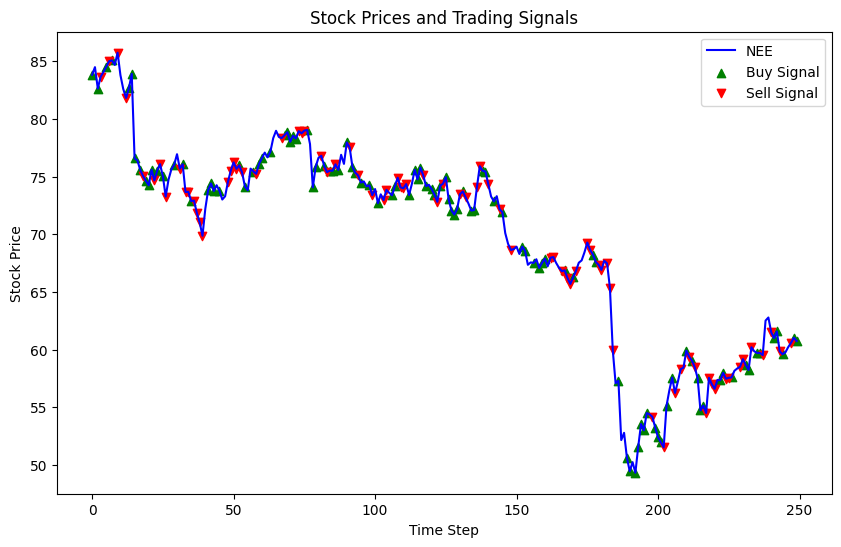

In [48]:
testing_prices = test_data['close']
testing_prices
# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i, action in enumerate(strategy3_actions) if action == 0]
sell_signals = [i for i, action in enumerate(strategy3_actions) if action == 2]
# Plot actual stock prices
plt.figure(figsize=(10, 6))
plt.plot(np.array(testing_prices), label=SELECTED_ISTRUMENTS[2], color='blue')

# Plot buy and sell signals based on the learned strategy
buy_signals = [i for i in buy_signals if i < len(testing_prices)]
sell_signals = [i for i in sell_signals if i < len(testing_prices)]

plt.scatter(buy_signals, [np.array(testing_prices.iloc[i]) for i in buy_signals], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals, [np.array(testing_prices.iloc[i]) for i in sell_signals], marker='v', color='red', label='Sell Signal')

plt.title('Stock Prices and Trading Signals')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [49]:
cumulative_portfolio_returns= [el +1 for el in portfolio_returns_simulation[:,0]]


strategy_3_value= [ el *100 for el in cumulative_portfolio_returns]
strategy_3_returns = pd.Series(strategy_3_value).pct_change()


stock_3_returns = test_data['close'].pct_change()

stock_3_value= np.array((1 + stock_3_returns).cumprod() * 100)

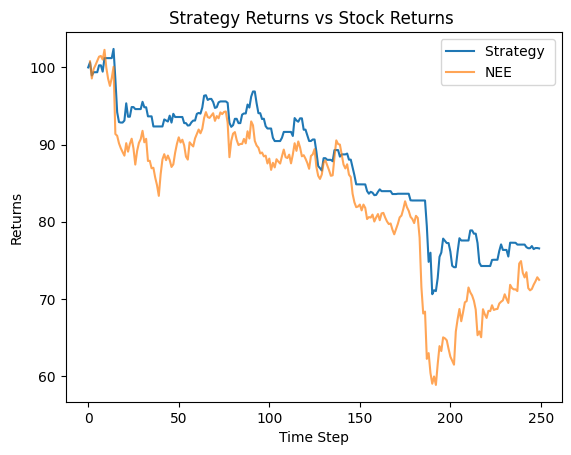

In [50]:


# Plot
plt.plot(strategy_3_value, label='Strategy ')
plt.plot(stock_3_value, label= SELECTED_ISTRUMENTS[2], alpha=0.7)
plt.legend()
plt.title('Strategy Returns vs Stock Returns ')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.show()

# **EQUALLY WEIGHTED PORTFOLIO**

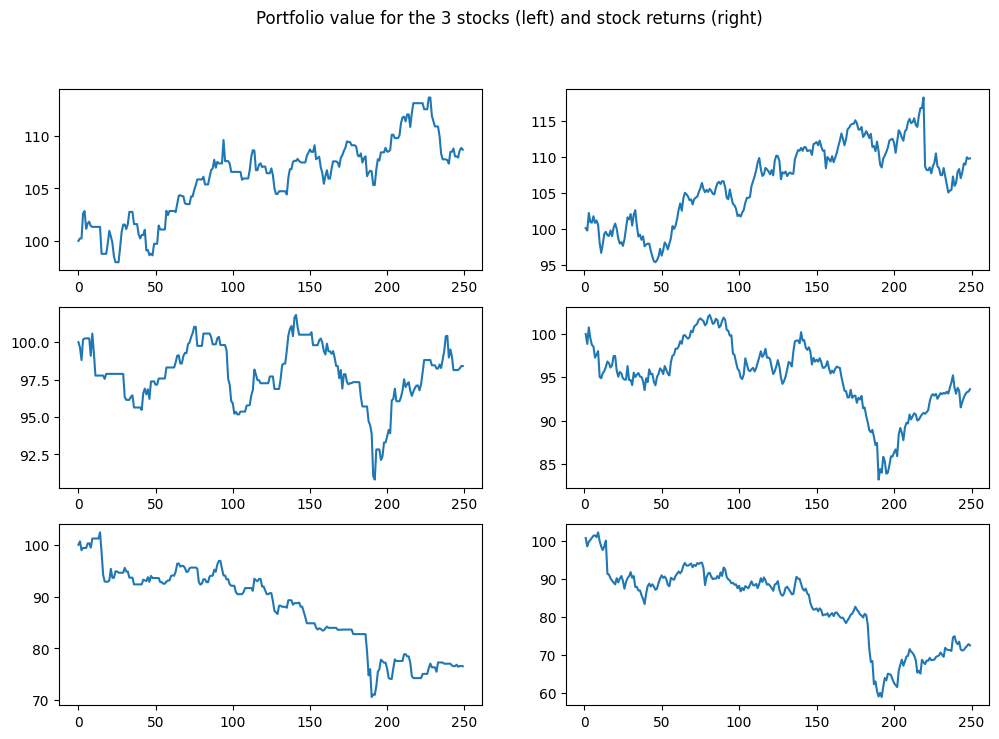

In [51]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Set the title for the entire figure
fig.suptitle('Portfolio value for the 3 stocks (left) and stock returns (right)')

# Plot on the left side (1st column)
axs[0, 0].plot(strategy_1_value)
axs[1, 0].plot(strategy_2_value)
axs[2, 0].plot(strategy_3_value)
CONFIG_TARGET_INSTRUMENTS
# Plot on the right side (2nd column)
axs[0, 1].plot(stock_1_value)
axs[1, 1].plot(stock_2_value)
axs[2, 1].plot(stock_3_value)

# EQUALLY WEIGHTED PORTOFOLIOS

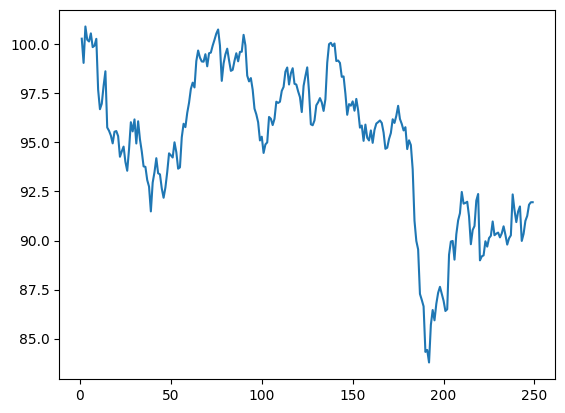

In [52]:
# DQN using values
DQN_portfolio_value = (stock_1_value +stock_2_value +stock_3_value)/3
plt.plot(DQN_portfolio_value)



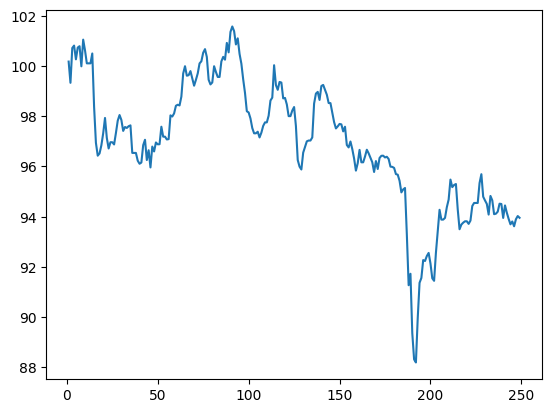

In [53]:
# DQN portfolio with returns
DQN_portfolio_returns =  ( (strategy_1_returns)+(strategy_2_returns)+(strategy_3_returns))/3
DQN_returns_portfolio_value = 100* np.cumprod(1 + DQN_portfolio_returns)
plt.plot(DQN_returns_portfolio_value)



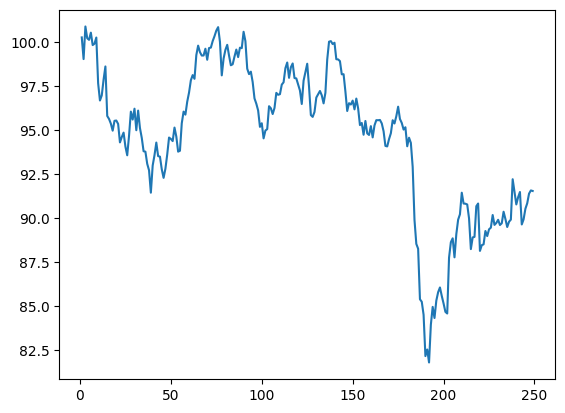

In [54]:
# Equally weighted 3 stocks
EW_portfolio_returns = (stock_1_returns+stock_2_returns+stock_3_returns)/3
EW_portfolio_value = np.array(100* np.cumprod(1 + EW_portfolio_returns))
plt.plot(EW_portfolio_value)

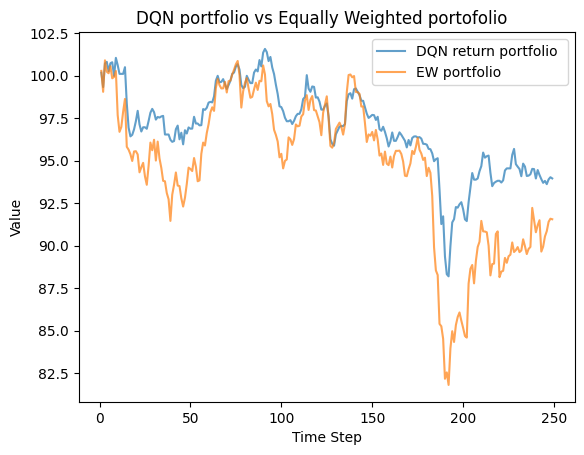

In [55]:
# Plot

plt.plot(DQN_returns_portfolio_value, label='DQN return portfolio ', alpha=0.7)
plt.plot(EW_portfolio_value, label='EW portfolio', alpha=0.7)

plt.legend()
plt.title('DQN portfolio vs Equally Weighted portofolio  ')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [56]:
np.savetxt('strategy_1_returns.csv', strategy_1_returns, delimiter=',')
np.savetxt('strategy_2_returns.csv', strategy_2_returns, delimiter=',')
np.savetxt('strategy_3_returns.csv', strategy_3_returns, delimiter=',')

In [57]:
def calculate_metrics(portfolio_returns, portfolio_value, portfolio_name):

    portfolio_returns = portfolio_returns[~np.isnan(portfolio_returns)]
    # Calculate metrics
    average_return = np.mean(portfolio_returns)
    volatility = np.std(portfolio_value)
    sharpe_ratio = average_return / volatility

    # Assuming a target return of 0 for Sortino Ratio
    downside_returns = np.minimum(0, portfolio_returns - 0)
    downside_deviation = np.sqrt(np.mean(downside_returns ** 2))
    sortino_ratio = average_return / downside_deviation

    # Calculate overall return (cumulative return)
    overall_return = np.prod(1 + portfolio_returns) - 1

    # Create a DataFrame
    metrics_dict = {
        "Volatility": volatility,
        "Average Return": average_return,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Overall Return": overall_return
    }

    return pd.DataFrame(metrics_dict , index=[portfolio_name])


In [58]:
portfolio1_metrics = calculate_metrics(strategy_1_returns,strategy_1_value,'portfolio_stock1_returns')
portfolio2_metrics = calculate_metrics(strategy_2_returns,strategy_2_value,'portfolio_stock2_returns')
portfolio3_metrics = calculate_metrics(strategy_3_returns,strategy_3_value,'portfolio_stock3_returns')
DQN_portofolio_metrics = calculate_metrics(DQN_portfolio_returns,DQN_returns_portfolio_value,'DQN_portfolio_returns')
stock1_metrics = calculate_metrics(stock_1_returns,stock_1_value,'stock1_returns')
stock2_metrics = calculate_metrics(stock_2_returns,stock_2_value,'stock2_returns')
stock3_metrics = calculate_metrics(stock_3_returns,stock_3_value,'stock3_returns')
EW_portofolio_metrics = calculate_metrics(EW_portfolio_returns,EW_portfolio_value,'EW_portfolio_returns')

all_portfolios_metrics = pd.concat([portfolio1_metrics, portfolio2_metrics, portfolio3_metrics, DQN_portofolio_metrics ,stock1_metrics ,stock2_metrics ,stock3_metrics, EW_portofolio_metrics ])

# Save to CSV
all_portfolios_metrics.to_csv('portfolio_metrics_DQN.csv')
all_portfolios_metrics.to_excel('portfolio_metrics_DQN.xlsx')
# Print results
print("Portfolio 1 Metrics:", portfolio1_metrics)
print("Portfolio 2 Metrics:", portfolio2_metrics)
print("Portfolio 3 Metrics:", portfolio3_metrics)
print("DQN_portofolio_metrics:", DQN_portofolio_metrics)
print("Stock 1 Metrics:", stock1_metrics)
print("Stock 2 Metrics:", stock2_metrics)
print("Stock 3 Metrics:", stock3_metrics)
print("EW_portofolio_metrics:", EW_portofolio_metrics)

Portfolio 1 Metrics:                           Volatility  Average Return  Sharpe Ratio  \
portfolio_stock1_returns    3.711676        0.000355      0.000096   

                          Sortino Ratio  Overall Return  
portfolio_stock1_returns       0.080197        0.086759  
Portfolio 2 Metrics:                           Volatility  Average Return  Sharpe Ratio  \
portfolio_stock2_returns    1.973208       -0.000048     -0.000025   

                          Sortino Ratio  Overall Return  
portfolio_stock2_returns       -0.01161       -0.015963  
Portfolio 3 Metrics:                           Volatility  Average Return  Sharpe Ratio  \
portfolio_stock3_returns    7.943569       -0.001011     -0.000127   

                          Sortino Ratio  Overall Return  
portfolio_stock3_returns      -0.109487       -0.234683  
DQN_portofolio_metrics:                        Volatility  Average Return  Sharpe Ratio  \
DQN_portfolio_returns    2.534281       -0.000235     -0.000093   

       